In [1]:
import warnings
import math
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    RandomizedSearchCV,
)
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import xgboost as xgb
import shap
from sklearn.inspection import PartialDependenceDisplay

### Load data

In [2]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

df = df.drop(columns=['inidoy', 'enddoy', 'ros_p_lg1'])

for col in df:
    print(col)

Loading dataset...
Dataset loaded
ros_p
duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_s_9_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
CBH_m_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
Cin_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
LFC_hPa_av
CCL_hPa_av
EL_m_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry


c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [3]:
nan_percent = df.isna().mean() * 100

# Imprime a % de NaNs por coluna
for col, perc in nan_percent.items():
    print(f"Coluna '{col}': {perc:.2f}% de NaNs")

df = df.loc[:, nan_percent <= 10]

for col in df:
    print(col)

Coluna 'ros_p': 0.00% de NaNs
Coluna 'duration_p': 0.00% de NaNs
Coluna 'elev_av': 0.00% de NaNs
Coluna 'aspect_av': 0.00% de NaNs
Coluna 'landform': 0.09% de NaNs
Coluna 'land_use': 9.38% de NaNs
Coluna '1_3y_fir_p': 0.00% de NaNs
Coluna '3_8y_fir_p': 0.00% de NaNs
Coluna '8_ny_fir_p': 0.00% de NaNs
Coluna 'fuel_model': 0.00% de NaNs
Coluna 'f_load_av': 0.00% de NaNs
Coluna 'sW_1m_av': 0.00% de NaNs
Coluna 'sW_3m_av': 0.00% de NaNs
Coluna 'sW_7_av': 0.00% de NaNs
Coluna 'sW_28_av': 0.00% de NaNs
Coluna 'sW_100_av': 0.00% de NaNs
Coluna 'sW_289_av': 0.00% de NaNs
Coluna 't_2m_C_av': 0.00% de NaNs
Coluna 'd_2m_C_av': 0.00% de NaNs
Coluna 'rh_2m_av': 0.00% de NaNs
Coluna 'VPD_Pa_av': 0.00% de NaNs
Coluna 'sP_hPa_av': 0.00% de NaNs
Coluna 'gp_m2s2_av': 0.00% de NaNs
Coluna 'dfmc_av': 0.00% de NaNs
Coluna 'HDW_av': 0.00% de NaNs
Coluna 'Haines_av': 0.00% de NaNs
Coluna 'FWI_12h_av': 0.00% de NaNs
Coluna 'DC_12h_av': 0.00% de NaNs
Coluna 'FFMC_12h_a': 0.00% de NaNs
Coluna 'wv10_kh_av': 0.00

### convert categorical variables into "category" type

In [4]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### create log vars

In [5]:
import numpy as np
import pandas as pd

# Seleciona colunas que NÃO são categóricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Cria novas variáveis com log natural
for col in num_cols:
    df[f'{col}_log'] = np.sign(df[col]) * np.log(np.abs(df[col]) + 1)

df = df.drop(columns=['ros_p'])

for col in df.columns:
    print(col)

duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
CCL_hPa_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry
ros_p_log
duration_p_log
elev_av_log
aspect_av_log
1_3y_fir_p_log
3_8y_fir_p_log
8_ny_fir_p_log


### remove nans from ros_p

In [6]:
n_before = len(df)
df = df.dropna(subset=['ros_p_log']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 0 rows with NaN in 'ros_p'. Remaining rows: 1173


### train and test datasets

In [7]:
# Define features (excluding specific columns)

train_features = [col for col in df.columns if col not in ('ros_p_log', 'inidoy', 'enddoy', "geometry")]
# Create initial X and y
X = df[train_features].copy()
y = df['ros_p_log'].copy()


# Remove invalid targets (-1) BEFORE cross-validation 

valid_mask = y != -1
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

print(f"Total valid samples for Cross-Validation: {len(X)}")

Total valid samples for Cross-Validation: 1173


### ALL VARS MODELLING

In [8]:
# ============================================================
# CONFIGURAÇÃO INICIAL
# ============================================================
import numpy as np
import pandas as pd
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*100)
print("🚀 REGRESSÃO LINEAR + REPEATED CV + IMPORTÂNCIA DAS FEATURES")
print("="*100)

# ============================================================
# DADOS
# ============================================================

print(f"📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")
print("   ✔ Target já está log-transformada.")

# ============================================================
# PIPELINE
# ============================================================
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# ============================================================
# REPEATED CROSS VALIDATION
# ============================================================
print("\n🔄 Repeated K-Fold Cross Validation (10 folds × 10 repeats)")
print("="*100)

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

cv_results = []
start = time.time()

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    cv_results.append([r2, rmse, mae])

elapsed = time.time() - start

cv_results = np.array(cv_results)
mean_r2, std_r2 = cv_results[:,0].mean(), cv_results[:,0].std()
mean_rmse, std_rmse = cv_results[:,1].mean(), cv_results[:,1].std()
mean_mae, std_mae = cv_results[:,2].mean(), cv_results[:,2].std()

print(f"📈 R²:   {mean_r2:.4f} ± {std_r2:.4f}")
print(f"📉 RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"📉 MAE:  {mean_mae:.4f} ± {std_mae:.4f}")
print(f"\n⏱ Tempo total: {elapsed:.1f} segundos")

# ============================================================
# TREINO FINAL NO CONJUNTO COMPLETO
# ============================================================
print("\n🎯 Treinando modelo final com todos os dados")
print("="*100)

final_model = pipeline.fit(X, y)
coef = final_model.named_steps["linreg"].coef_

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": coef,
    "importance": np.abs(coef)
}).sort_values("importance", ascending=False)

print("Top 10 variáveis mais importantes:")
print(coef_df.head(10))


🚀 REGRESSÃO LINEAR + REPEATED CV + IMPORTÂNCIA DAS FEATURES
📊 X shape: (1173, 176)
📊 y shape: (1173,)
   ✔ Target já está log-transformada.

🔄 Repeated K-Fold Cross Validation (10 folds × 10 repeats)


📈 R²:   0.4873 ± 0.0686
📉 RMSE: 0.7745 ± 0.0413
📉 MAE:  0.6073 ± 0.0230

⏱ Tempo total: 1.1 segundos

🎯 Treinando modelo final com todos os dados
Top 10 variáveis mais importantes:
            feature       coef  importance
97     sW_1m_av_log  88.103476   88.103476
101   sW_100_av_log -54.530039   54.530039
63        gp_300_av  28.979876   28.979876
100    sW_28_av_log -28.843348   28.843348
149   gp_300_av_log -27.959622   27.959622
169  LCL_hPa_av_log  26.185668   26.185668
98     sW_3m_av_log -24.548930   24.548930
62        gp_500_av -19.940559   19.940559
148   gp_500_av_log  19.702266   19.702266
61        gp_700_av -19.596289   19.596289



🔍 Forward Feature Selection usando MAE (1ª variável = melhor univariada, sem repetir linear/log, max 10 iterações)


➡ Iteração #1 – melhor univariada selecionada: HDW_av
   ⭐ MAE = 599.7702, R² = 0.1448

➡ Iteração #2 – 2/176 features
   ✔ Variável adicionada: wv_850_av
   ⭐ MAE = 568.7569, R² = 0.2305

➡ Iteração #3 – 3/176 features
   ✔ Variável adicionada: duration_p
   ⭐ MAE = 545.2963, R² = 0.3267

➡ Iteração #4 – 4/176 features
   ✔ Variável adicionada: Cape_av_log
   ⭐ MAE = 526.0040, R² = 0.3739

➡ Iteração #5 – 5/176 features
   ✔ Variável adicionada: gT_8_7_av
   ⭐ MAE = 516.6532, R² = 0.3872

➡ Iteração #6 – 6/176 features
   ✔ Variável adicionada: 3_8y_fir_p_log
   ⭐ MAE = 505.7058, R² = 0.4103

➡ Iteração #7 – 7/176 features
   ✔ Variável adicionada: DC_12h_av_log
   ⭐ MAE = 499.3189, R² = 0.4335

➡ Iteração #8 – 8/176 features
   ✔ Variável adicionada: 8_ny_fir_p_log
   ⭐ MAE = 493.7055, R² = 0.4392

➡ Iteração #9 – 9/176 features
   ✔ Variável adicionada: wSdir_5_av_log
   ⭐ MAE = 490.1958, R² = 0.4480

➡ Iteração #10 – 10/176 features
   ✔ Variável adicionada: vwv_500_av
   ⭐ MAE = 4

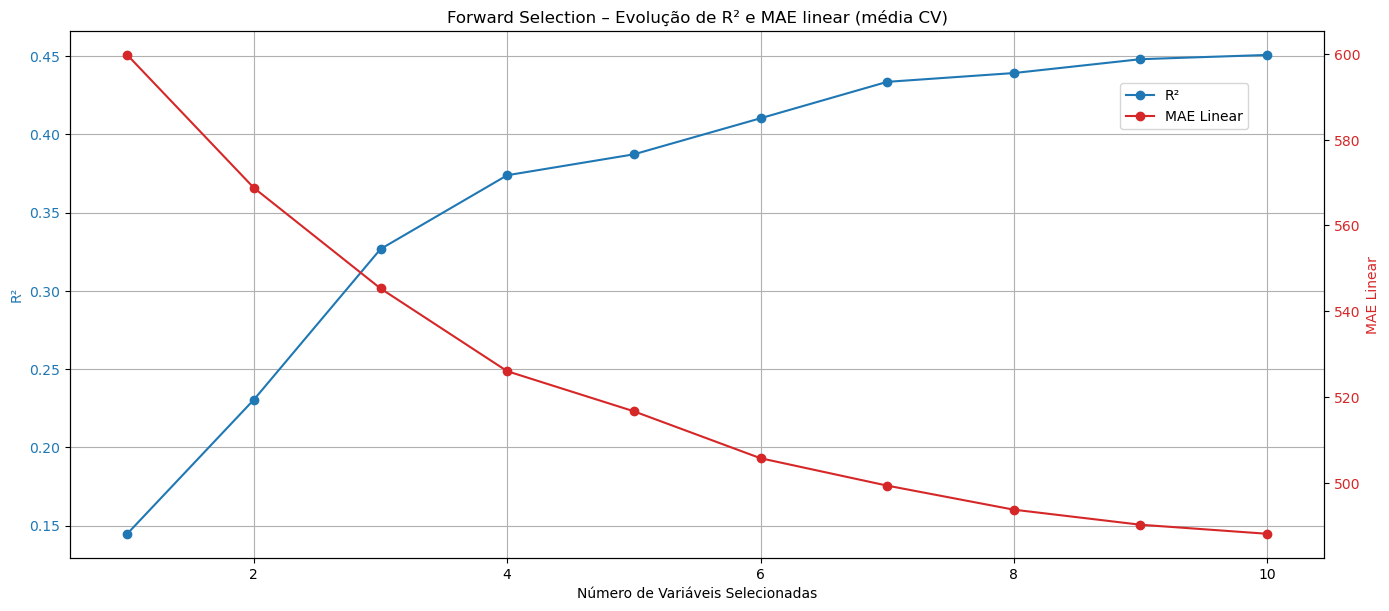

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error

# ============================================================
# FORWARD FEATURE SELECTION usando MAE (com R² médio por CV)
# ============================================================

print("\n🔍 Forward Feature Selection usando MAE (1ª variável = melhor univariada, sem repetir linear/log, max 10 iterações)")
print("="*100)

features = list(X.columns)
remaining_features = features.copy()
selected_features = []
results = []

# Configurações do RepeatedKFold
n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

max_iters = 10
iteration = 1

# ============================================================
# Função para calcular métricas médias por RepeatedKFold
# ============================================================
def evaluate_cv_r2_mae(features_subset):
    n_samples = len(y)
    y_pred_sum = np.zeros(n_samples)
    y_pred_count = np.zeros(n_samples)
    y_test_sum = np.zeros(n_samples)
    y_test_count = np.zeros(n_samples)

    for train_idx, test_idx in rkf.split(X[features_subset]):
        X_train, X_test = X.iloc[train_idx][features_subset], X.iloc[test_idx][features_subset]
        y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Treina o modelo
        pipeline.fit(X_train, y_train)
        y_pred_fold = pipeline.predict(X_test)

        # acumula somas e contagens para média
        y_pred_sum[test_idx] += y_pred_fold
        y_pred_count[test_idx] += 1
        y_test_sum[test_idx] += y_test_fold.values
        y_test_count[test_idx] += 1

    # médias por observação
    avg_pred_log = y_pred_sum / y_pred_count
    avg_actual_log = y_test_sum / y_test_count

    # converter log → linear
    avg_pred_linear = np.sign(avg_pred_log) * (np.expm1(np.abs(avg_pred_log)))
    avg_actual_linear = np.sign(avg_actual_log) * (np.expm1(np.abs(avg_actual_log)))

    # métricas
    r2 = r2_score(avg_actual_log, avg_pred_log)           # R² log-transform
    mae_linear = mean_absolute_error(avg_actual_linear, avg_pred_linear)  # MAE linear

    return r2, mae_linear

# ============================================================
# 1) Melhor variável univariada
# ============================================================
best_mae = np.inf
best_feature = None

for f in remaining_features:
    r2_cv, mae_cv = evaluate_cv_r2_mae([f])
    if mae_cv < best_mae:
        best_mae = mae_cv
        best_feature = f

selected_features.append(best_feature)
remaining_features.remove(best_feature)

# remover versão linear/log oposta
alt_var = best_feature.replace("_log","") if best_feature.endswith("_log") else best_feature + "_log"
if alt_var in remaining_features:
    remaining_features.remove(alt_var)

# métricas finais univariadas
r2_final, mae_final = evaluate_cv_r2_mae(selected_features)
results.append([iteration, best_feature, r2_final, mae_final, best_mae])

print(f"➡ Iteração #1 – melhor univariada selecionada: {best_feature}")
print(f"   ⭐ MAE = {best_mae:.4f}, R² = {r2_final:.4f}")

# ============================================================
# 2) Forward Selection normal + break após 10 iterações
# ============================================================
iteration += 1

while len(remaining_features) > 0:
    if iteration > max_iters:
        print(f"\n⛔ Limite de {max_iters} iterações atingido. Forward Selection interrompido.")
        break

    best_mae = np.inf
    best_feature = None

    print(f"\n➡ Iteração #{iteration} – {len(selected_features)+1}/{len(features)} features")

    for f in remaining_features:
        test_features = selected_features + [f]
        r2_cv, mae_cv = evaluate_cv_r2_mae(test_features)
        if mae_cv < best_mae:
            best_mae = mae_cv
            best_feature = f

    selected_features.append(best_feature)
    remaining_features.remove(best_feature)

    # remover versão linear/log oposta
    alt_var = best_feature.replace("_log","") if best_feature.endswith("_log") else best_feature + "_log"
    if alt_var in remaining_features:
        remaining_features.remove(alt_var)

    # métricas finais com features selecionadas
    r2_final, mae_final = evaluate_cv_r2_mae(selected_features)
    results.append([iteration, best_feature, r2_final, mae_final, best_mae])

    print(f"   ✔ Variável adicionada: {best_feature}")
    print(f"   ⭐ MAE = {best_mae:.4f}, R² = {r2_final:.4f}")

    iteration += 1

# ============================================================
# Salvar resultados
# ============================================================
ffs_df = pd.DataFrame(results, columns=["iteration", "added_feature", "R2", "MAE_linear", "MAE_selection"])

# ============================================================
# Gráfico combinado R² e MAE linear
# ============================================================
fig, ax1 = plt.subplots(figsize=(14,6))

color_r2 = 'tab:blue'
ax1.set_xlabel("Número de Variáveis Selecionadas")
ax1.set_ylabel("R²", color=color_r2)
ax1.plot(ffs_df["iteration"], ffs_df["R2"], marker="o", color=color_r2, label="R²")
ax1.tick_params(axis='y', labelcolor=color_r2)
ax1.grid(True)

ax2 = ax1.twinx()
color_mae = 'tab:red'
ax2.set_ylabel("MAE Linear", color=color_mae)
ax2.plot(ffs_df["iteration"], ffs_df["MAE_linear"], marker="o", color=color_mae, label="MAE Linear")
ax2.tick_params(axis='y', labelcolor=color_mae)

fig.tight_layout()
plt.title("Forward Selection – Evolução de R² e MAE linear (média CV)")
fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9))
plt.show()



✅ Variáveis selecionadas (7): ['HDW_av', 'wv_850_av', 'duration_p', 'Cape_av_log', 'gT_8_7_av', '3_8y_fir_p_log', 'DC_12h_av_log']

📊 MÉTRICAS COM CROSS-VALIDATION (MÉTODO 1)
R² (log scale)   = 0.4338
RMSE (log)       = 0.8197
MAE (log)        = 0.6547
RMSE (linear)    = 913.3924
MAE (linear)     = 499.4544

Intercept (ln(a)): 6.2374
Coeficientes:
  HDW_av: 0.2240
  wv_850_av: 0.1116
  duration_p: -0.4613
  Cape_av_log: -0.2202
  gT_8_7_av: -0.1744
  3_8y_fir_p_log: 0.1756
  DC_12h_av_log: 0.2365

Equação final do modelo:
ln(ROS) = 6.2374 + 0.2240*HDW_av + 0.1116*wv_850_av + -0.4613*duration_p + -0.2202*Cape_av_log + -0.1744*gT_8_7_av + 0.1756*3_8y_fir_p_log + 0.2365*DC_12h_av_log


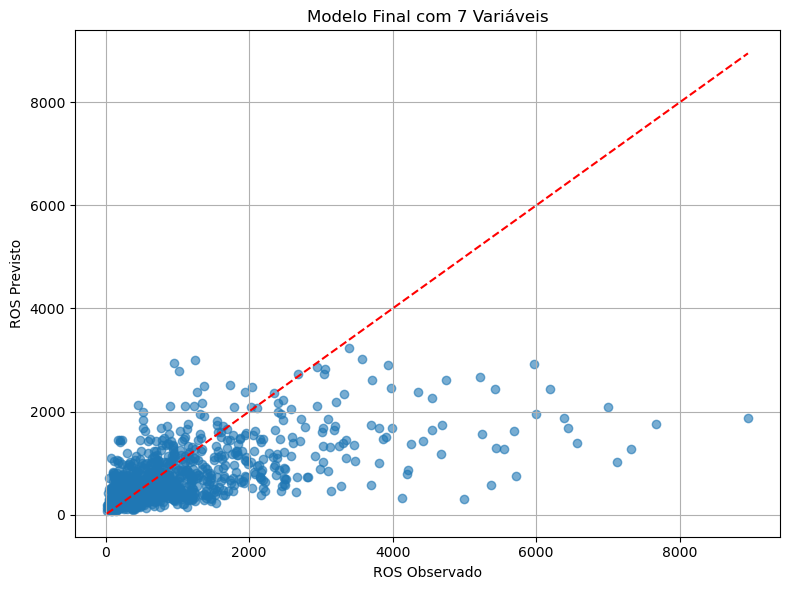


✅ Modelo salvo em '..\..\Data\Models\model_linear_ffs.pkl'


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.model_selection import RepeatedKFold

# ------------------------------------------------------------
# 1. Definir número de variáveis que quer usar
# ------------------------------------------------------------
n_selected = 7

final_features = ffs_df["added_feature"].iloc[:n_selected].tolist()
print(f"\n✅ Variáveis selecionadas ({n_selected}): {final_features}")

# ------------------------------------------------------------
# 2. Dados finais
# ------------------------------------------------------------
X_final = X[final_features]
y_final = y  # log scale

# ------------------------------------------------------------
# 3. MÉTRICAS COM REPEATED CV (OUT-OF-SAMPLE) — MÉTODO 1
# ------------------------------------------------------------
from sklearn.model_selection import KFold

# Igual ao primeiro código: KFold 5 splits, shuffle=True
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# UMA previsão out-of-sample por observação
y_pred_cv = np.full(len(y_final), np.nan)

for train_idx, test_idx in kf.split(X_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train = y_final.iloc[train_idx]

    model = pipeline.fit(X_train, y_train)
    y_pred_cv[test_idx] = model.predict(X_test)

# ---- métricas em log
r2_cv = r2_score(y_final, y_pred_cv)
mae_log_cv = mean_absolute_error(y_final, y_pred_cv)
rmse_log_cv = np.sqrt(mean_squared_error(y_final, y_pred_cv))

# ---- métricas em escala linear
y_true_linear = np.exp(y_final)
y_pred_linear = np.exp(y_pred_cv)

mae_linear_cv = mean_absolute_error(y_true_linear, y_pred_linear)
rmse_linear_cv = np.sqrt(mean_squared_error(y_true_linear, y_pred_linear))

print("\n📊 MÉTRICAS COM CROSS-VALIDATION (MÉTODO 1)")
print(f"R² (log scale)   = {r2_cv:.4f}")
print(f"RMSE (log)       = {rmse_log_cv:.4f}")
print(f"MAE (log)        = {mae_log_cv:.4f}")
print(f"RMSE (linear)    = {rmse_linear_cv:.4f}")
print(f"MAE (linear)     = {mae_linear_cv:.4f}")


# ------------------------------------------------------------
# 4. Treinar MODELO FINAL (todos os dados)
# ------------------------------------------------------------
final_model = pipeline.fit(X_final, y_final)
y_pred_final = final_model.predict(X_final)

# ------------------------------------------------------------
# 5. Coeficientes e equação final
# ------------------------------------------------------------
intercept = final_model.named_steps["linreg"].intercept_
coef = final_model.named_steps["linreg"].coef_

print(f"\nIntercept (ln(a)): {intercept:.4f}")
print("Coeficientes:")
for var, c in zip(final_features, coef):
    print(f"  {var}: {c:.4f}")

equation_terms = [f"{c:.4f}*{var}" for var, c in zip(final_features, coef)]
equation = "ln(ROS) = {:.4f} + ".format(intercept) + " + ".join(equation_terms)

print("\nEquação final do modelo:")
print(equation)

# ------------------------------------------------------------
# 6. Plot (apenas visualização)
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(np.exp(y_final), np.exp(y_pred_final), alpha=0.6)
plt.plot(
    [np.exp(y_final).min(), np.exp(y_final).max()],
    [np.exp(y_final).min(), np.exp(y_final).max()],
    "r--"
)
plt.xlabel("ROS Observado")
plt.ylabel("ROS Previsto")
plt.title(f"Modelo Final com {n_selected} Variáveis")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. Salvar modelo final
# ------------------------------------------------------------
model_filename = r"..\..\Data\Models\model_linear_ffs.pkl"

with open(model_filename, "wb") as f:
    pickle.dump(final_model, f)

print(f"\n✅ Modelo salvo em '{model_filename}'")


In [26]:
# ============================================================
# SHAP + PREDIÇÕES CV + MERGE COM SHAPEFILE (modelo final)
# ============================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------------------------------------
# 1. Variáveis e target do modelo final
# ------------------------------------------------------------
X_shap = X_final.copy()
y_shap = y_final.copy()
final_features = X_shap.columns.tolist()

# ------------------------------------------------------------
# 2. Configurações de CV
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
threshold = 35

rkf = RepeatedKFold(
    n_splits=n_splits,
    n_repeats=n_repeats,
    random_state=random_state
)

# DataFrames para armazenar resultados
shap_results = pd.DataFrame(
    index=X_shap.index,
    columns=[
        'ros_p_log','ros_p_linear',
        'PredROS_log','PredROS_linear',
        'PredDiff','Err_pct',
        'Error_p_abs','bad_pred'
    ]
)

shap_values_all = pd.DataFrame(
    index=X_shap.index,
    columns=final_features
)

# ------------------------------------------------------------
# 3. Repeated CV: acumular previsões OOS
# ------------------------------------------------------------
n_samples = len(X_shap)

y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)

y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

print("🔄 Calculando PredROS médias com Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_shap), total=n_splits * n_repeats):

    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    model_cv = pipeline.fit(X_train, y_train)
    y_pred_test = model_cv.predict(X_test)

    # acumular somas e contagens
    y_pred_sum[test_idx] += y_pred_test
    y_pred_count[test_idx] += 1

    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ------------------------------------------------------------
# 4. Médias por observação (log)
# ------------------------------------------------------------
avg_pred_log = y_pred_sum / y_pred_count
avg_actual_log = y_test_sum / y_test_count

# ------------------------------------------------------------
# 5. Inversão do log (EXATAMENTE COMO PEDIDO)
# ------------------------------------------------------------
def safe_log_inverse(y_log):
    return np.sign(y_log) * np.expm1(np.abs(y_log))

avg_pred_linear = safe_log_inverse(avg_pred_log)
avg_actual_linear = safe_log_inverse(avg_actual_log)

# ------------------------------------------------------------
# 6. Atualizar DataFrame shap_results (ERROS CORRETOS)
# ------------------------------------------------------------
shap_results['PredROS_log'] = avg_pred_log
shap_results['ros_p_log'] = avg_actual_log

shap_results['PredROS_linear'] = avg_pred_linear
shap_results['ros_p_linear'] = avg_actual_linear

# erro real
shap_results['PredDiff'] = avg_pred_linear - avg_actual_linear
shap_results['Err_pct'] = (shap_results['PredDiff'] / avg_actual_linear) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > threshold

# ------------------------------------------------------------
# 7. Métricas CV globais (baseadas em médias OOS)
# ------------------------------------------------------------
mae_log = mean_absolute_error(avg_actual_log, avg_pred_log)
rmse_log = np.sqrt(mean_squared_error(avg_actual_log, avg_pred_log))

mae_linear = mean_absolute_error(avg_actual_linear, avg_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(avg_actual_linear, avg_pred_linear))

print(f"MAE log = {mae_log:.3f}, RMSE log = {rmse_log:.3f}")
print(f"MAE linear = {mae_linear:.2f}, RMSE linear = {rmse_linear:.2f}")

# ------------------------------------------------------------
# 8. SHAP values (modelo final)
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para todas as features do modelo final...")

explainer = shap.LinearExplainer(
    final_model.named_steps["linreg"],
    X_shap,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_shap)

shap_values_df = pd.DataFrame(
    shap_values,
    columns=final_features,
    index=X_shap.index
)

# ------------------------------------------------------------
# 9. Merge com GeoDataFrame
# ------------------------------------------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)

shap_results_reset = shap_results.reset_index(drop=True)
shap_values_reset = shap_values_df.reset_index(drop=True)
shap_values_reset = shap_values_reset.add_prefix('shap_')

merged_gdf_gpd = pd.concat(
    [gdf, shap_results_reset, shap_values_reset],
    axis=1
)

merged_gdf_gpd = gpd.GeoDataFrame(
    merged_gdf_gpd,
    geometry='geometry',
    crs=gdf.crs
)

# ------------------------------------------------------------
# 10. Salvar shapefile e CSV
# ------------------------------------------------------------
out_shapefile = r"..\..\Data\Models\PT_FireProg_model_SHAP_Linear.shp"
merged_gdf_gpd.to_file(out_shapefile)

print(f"\n✅ SHAP + PredROS + erros + geometria salvos em shapefile:")
print(out_shapefile)

out_csv = r"..\..\Data\Models\PT_FireProg_model_SHAP_Linear.csv"
merged_gdf_gpd.drop(columns='geometry').to_csv(out_csv, index=False)

print(f"\n✅ SHAP + PredROS + erros salvos também em CSV:")
print(out_csv)


🔄 Calculando PredROS médias com Repeated CV...


100%|██████████| 50/50 [00:00<00:00, 219.28it/s]


MAE log = 0.655, RMSE log = 0.820
MAE linear = 499.75, RMSE linear = 913.29
🔹 Calculando SHAP values para todas as features do modelo final...

✅ SHAP + PredROS + erros + geometria salvos em shapefile:
..\..\Data\Models\PT_FireProg_model_SHAP_Linear.shp

✅ SHAP + PredROS + erros salvos também em CSV:
..\..\Data\Models\PT_FireProg_model_SHAP_Linear.csv


R² log = 0.523, MAE log = 0.594, RMSE log = 0.752
R² linear = 0.427, MAE linear = 469.9, RMSE linear = 832.9


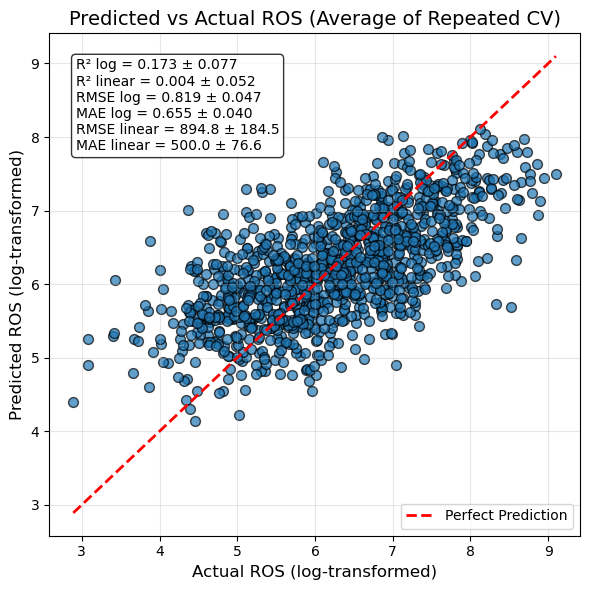

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================================
# 1. Accumulate sums and counts for averages (like Script 1)
# ============================================================
n_samples = len(y)
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

for train_idx, test_idx in rkf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_pred = pipeline.fit(X_train, y_train).predict(X_test)

    # Accumulate sums and counts
    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ============================================================
# 2. Calculate averages per observation
# ============================================================
y_pred_log = y_pred_sum / y_pred_count
y_true_log = y_test_sum / y_test_count

# Safe log inverse function
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

y_pred_linear = inverse_safe_log(y_pred_log)
y_true_linear = inverse_safe_log(y_true_log)

# ============================================================
# 3. Metrics
# ============================================================
r2_log_cv = r2_score(y_true_log, y_pred_log)
mae_log_cv = mean_absolute_error(y_true_log, y_pred_log)
rmse_log_cv = np.sqrt(mean_squared_error(y_true_log, y_pred_log))

r2_linear_cv = r2_score(y_true_linear, y_pred_linear)
mae_linear_cv = mean_absolute_error(y_true_linear, y_pred_linear)
rmse_linear_cv = np.sqrt(mean_squared_error(y_true_linear, y_pred_linear))

print(f"R² log = {r2_log_cv:.3f}, MAE log = {mae_log_cv:.3f}, RMSE log = {rmse_log_cv:.3f}")
print(f"R² linear = {r2_linear_cv:.3f}, MAE linear = {mae_linear_cv:.1f}, RMSE linear = {rmse_linear_cv:.1f}")

# ============================================================
# 4. Scatter plot Predicted vs Actual (com ± std)
# ============================================================

# Calcular MAE e RMSE por fold (log e linear)
mae_folds_log = []
rmse_folds_log = []
mae_folds_linear = []
rmse_folds_linear = []

for train_idx, test_idx in rkf.split(X_shap):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    y_pred_fold = pipeline.fit(X_train, y_train).predict(X_test)
    y_test_linear_fold = safe_log_inverse(y_test)
    y_pred_linear_fold = safe_log_inverse(y_pred_fold)

    mae_folds_log.append(mean_absolute_error(y_test, y_pred_fold))
    rmse_folds_log.append(np.sqrt(mean_squared_error(y_test, y_pred_fold)))
    mae_folds_linear.append(mean_absolute_error(y_test_linear_fold, y_pred_linear_fold))
    rmse_folds_linear.append(np.sqrt(mean_squared_error(y_test_linear_fold, y_pred_linear_fold)))

# Média ± std
r2_log_mean, r2_log_std = np.mean(r2_folds_log), np.std(r2_folds_log)
r2_linear_mean, r2_linear_std = np.mean(r2_folds_linear), np.std(r2_folds_linear)
mae_log_mean, mae_log_std = np.mean(mae_folds_log), np.std(mae_folds_log)
rmse_log_mean, rmse_log_std = np.mean(rmse_folds_log), np.std(rmse_folds_log)
mae_linear_mean, mae_linear_std = np.mean(mae_folds_linear), np.std(mae_folds_linear)
rmse_linear_mean, rmse_linear_std = np.mean(rmse_folds_linear), np.std(rmse_folds_linear)

plt.figure(figsize=(6, 6))
plt.scatter(avg_actual_log, avg_pred_log, alpha=0.7, edgecolor='k', s=50)

min_val = min(avg_actual_log.min(), avg_pred_log.min())
max_val = max(avg_actual_log.max(), avg_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val],
         'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Average of Repeated CV)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² log = {r2_log_mean:.3f} ± {r2_log_std:.3f}\n'
    f'R² linear = {r2_linear_mean:.3f} ± {r2_linear_std:.3f}\n'
    f'RMSE log = {rmse_log_mean:.3f} ± {rmse_log_std:.3f}\n'
    f'MAE log = {mae_log_mean:.3f} ± {mae_log_std:.3f}\n'
    f'RMSE linear = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f}\n'
    f'MAE linear = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



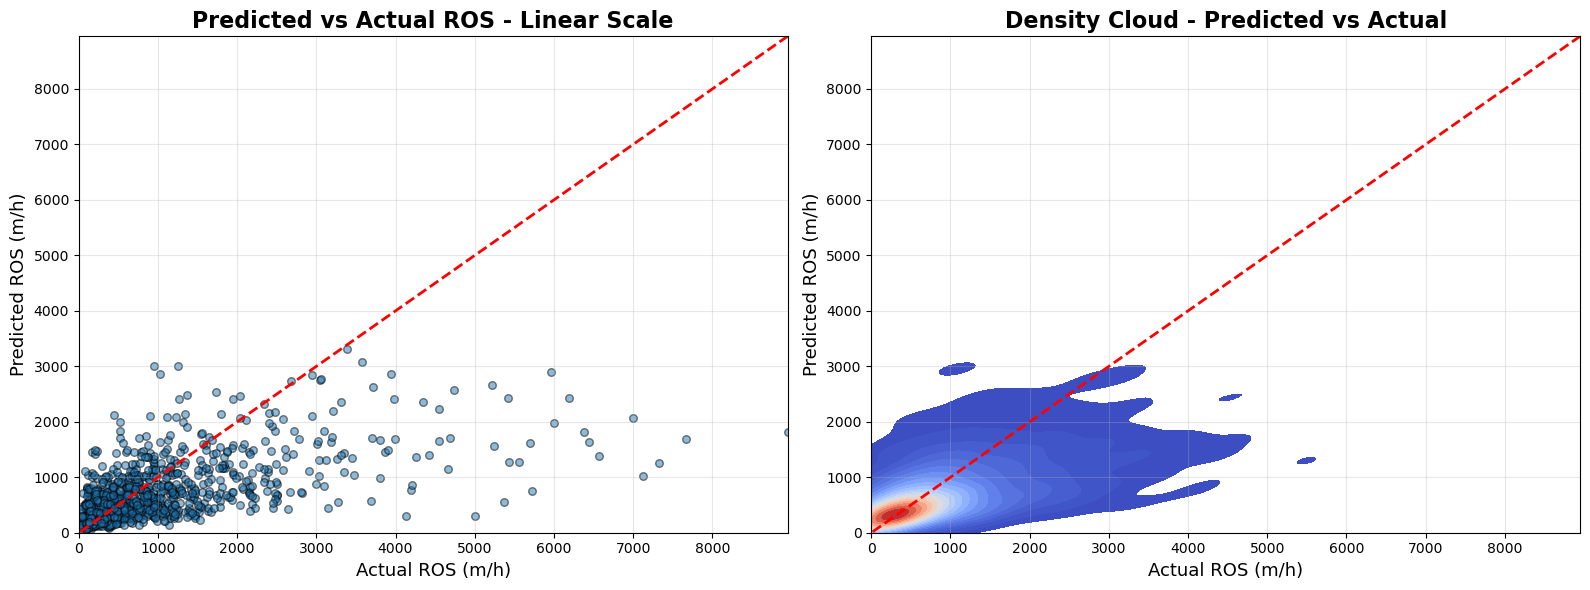

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# 1. Converter de log → linear
# ============================================================
y_actual_linear = inverse_safe_log(avg_actual_log)
y_pred_linear = inverse_safe_log(avg_pred_log)

# ============================================================
# 2. Metrics using Repeated CV averages
# ============================================================
r2_linear_cv = r2_score(y_actual_linear, y_pred_linear)
rmse_linear_cv = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_cv = mean_absolute_error(y_actual_linear, y_pred_linear)

metrics_text = (
    f'Overall Metrics (CV average):\n'
    f'R² = {r2_linear_cv:.3f}\n'
    f'RMSE = {rmse_linear_cv:.1f} m/h\n'
    f'MAE = {mae_linear_cv:.1f} m/h\n'
    f'N samples = {len(y_actual_linear)}'
)


# ============================================================
# 3. Scatter + 2D KDE plot
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# -------------------------
# Left panel: Scatter plot
# -------------------------
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# -------------------------
# Right panel: 2D KDE density plot
# -------------------------
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


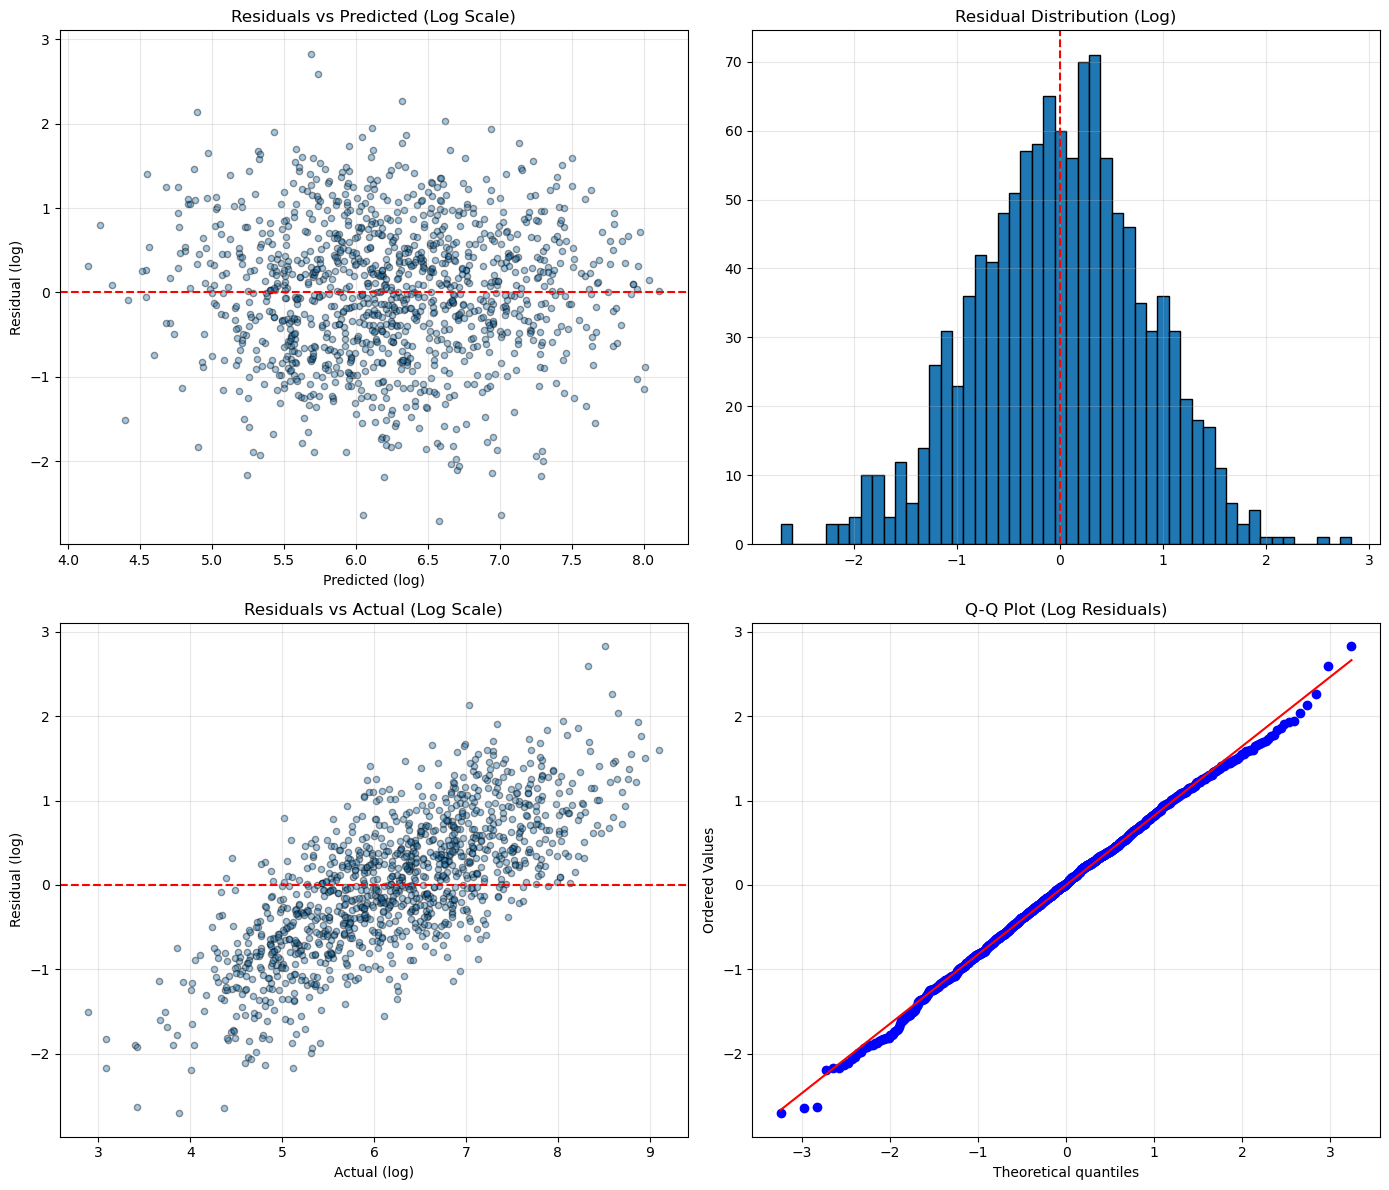

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# ============================================================
# 1. Usar médias do Repeated K-Fold
# ============================================================
avg_actual = avg_actual_log   # valores reais médios (log)
avg_pred   = avg_pred_log     # valores previstos médios (log)

# Conversão para escala linear, se quiser usar depois
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos na escala log
residuals_log = avg_actual - avg_pred

# ============================================================
# 2. Plots de diagnóstico dos resíduos
# ============================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# Residuals vs Predicted
# -------------------------
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# -------------------------
# Histogram of residuals
# -------------------------
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# -------------------------
# Residuals vs Actual
# -------------------------
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# -------------------------
# Q-Q Plot
# -------------------------
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


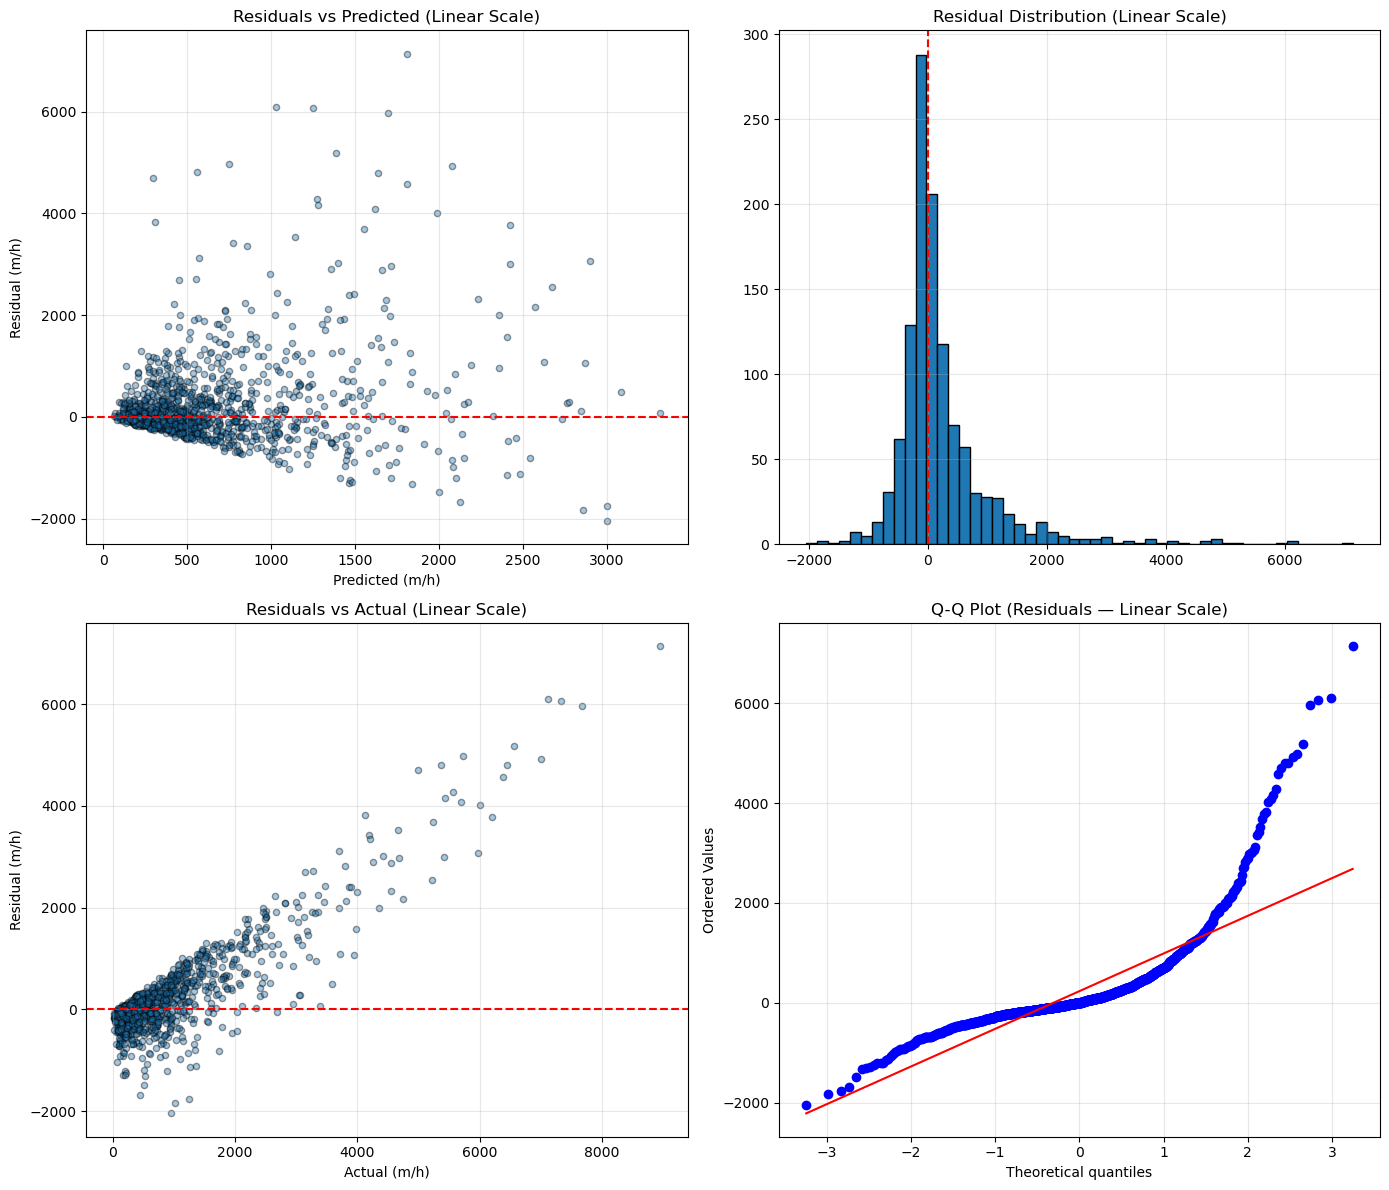

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = avg_actual_log      # já calculado antes
avg_pred_log   = avg_pred_log        # já calculado antes

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 418  (35.6%)
Bad Predictions  : 755  (64.4%)


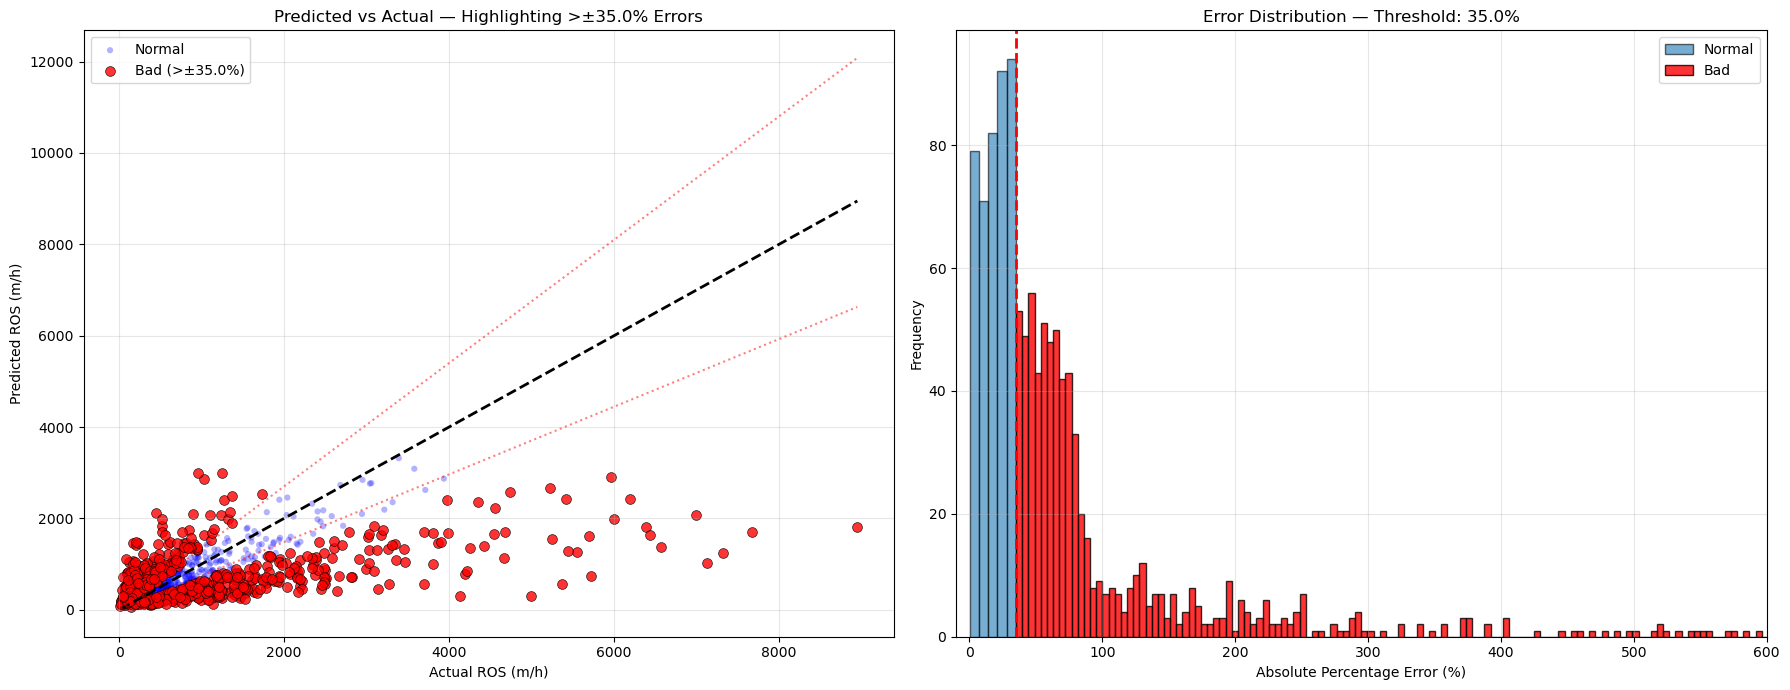

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()


# benchmark 

R² log (CV médio) = 0.173, MAE log = 0.782, RMSE log = 0.982
R² linear (CV médio) = 0.004, MAE linear = 596.4, RMSE linear = 1099.5


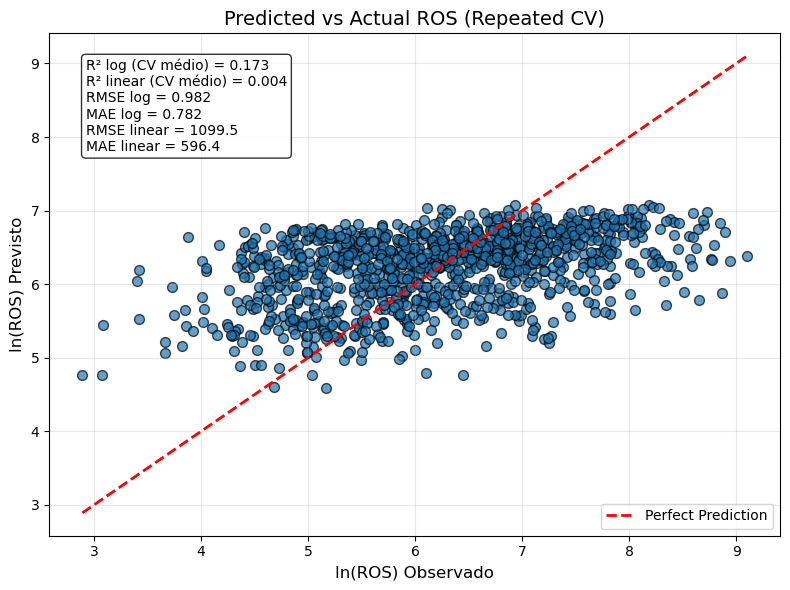


✅ Modelo salvo em 'model_benchmark_cv.pkl'


In [32]:
# ============================================================
# MODELO LOG-LINEAR ROS ~ wv10_log + dfmc + LFMC (CV médio)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------------------------------------
# 1. Selecionar variáveis
# ------------------------------------------------------------
X_model = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]]  # ajuste se nomes diferentes
y_model = y  # ln(ROS), já log-transformado

# ------------------------------------------------------------
# 2. Criar pipeline
# ------------------------------------------------------------
pipeline_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# ------------------------------------------------------------
# 3. Configuração RepeatedKFold
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# ------------------------------------------------------------
# 4. Repeated CV: acumular somas e contagens
# ------------------------------------------------------------
n_samples = len(X_model)
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred = pipeline_model.fit(X_train, y_train).predict(X_test)

    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ------------------------------------------------------------
# 5. Médias por observação
# ------------------------------------------------------------
y_pred_log = y_pred_sum / y_pred_count
y_actual_log = y_test_sum / y_test_count

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

y_pred_linear = inverse_safe_log(y_pred_log)
y_actual_linear = inverse_safe_log(y_actual_log)

# ------------------------------------------------------------
# 6. Métricas por fold (R² médio)
# ------------------------------------------------------------
r2_folds_log = []
r2_folds_linear = []

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred_fold = pipeline_model.fit(X_train, y_train).predict(X_test)

    r2_folds_log.append(r2_score(y_test, y_pred_fold))
    r2_folds_linear.append(r2_score(inverse_safe_log(y_test), inverse_safe_log(y_pred_fold)))

r2_log_cv = np.mean(r2_folds_log)
r2_linear_cv = np.mean(r2_folds_linear)

# Outras métricas
mae_log = mean_absolute_error(y_actual_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_actual_log, y_pred_log))
mae_linear = mean_absolute_error(y_actual_linear, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))

print(f"R² log (CV médio) = {r2_log_cv:.3f}, MAE log = {mae_log:.3f}, RMSE log = {rmse_log:.3f}")
print(f"R² linear (CV médio) = {r2_linear_cv:.3f}, MAE linear = {mae_linear:.1f}, RMSE linear = {rmse_linear:.1f}")

# ------------------------------------------------------------
# 7. Scatter plot Predicted vs Actual
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_actual_log, y_pred_log, alpha=0.7, edgecolor='k', s=50)
min_val = min(y_actual_log.min(), y_pred_log.min())
max_val = max(y_actual_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title("Predicted vs Actual ROS (Repeated CV)", fontsize=14)
plt.xlabel("ln(ROS) Observado", fontsize=12)
plt.ylabel("ln(ROS) Previsto", fontsize=12)
plt.text(
    0.05, 0.95,
    f'R² log (CV médio) = {r2_log_cv:.3f}\n'
    f'R² linear (CV médio) = {r2_linear_cv:.3f}\n'
    f'RMSE log = {rmse_log:.3f}\n'
    f'MAE log = {mae_log:.3f}\n'
    f'RMSE linear = {rmse_linear:.1f}\n'
    f'MAE linear = {mae_linear:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. Salvar modelo
# ------------------------------------------------------------
with open(r"..\..\Data\Models\model_benchmark_cv.pkl", "wb") as f:
    pickle.dump(pipeline_model, f)

print("\n✅ Modelo salvo em 'model_benchmark_cv.pkl'")


In [33]:
# ============================================================
# SHAP + PREDIÇÕES CV + MERGE COM SHAPEFILE (log-linear ROS)
# ============================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Selecionar variáveis e target
# ------------------------------------------------------------
X_shap = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]].copy()
y_shap = y.copy()  # ln(ROS)
final_features = X_shap.columns.tolist()

# ------------------------------------------------------------
# 2. Configurações de CV
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# ------------------------------------------------------------
# 3. Repeated CV: acumular somas e contagens
# ------------------------------------------------------------
n_samples = len(X_shap)
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

print("🔄 Calculando PredROS médias com Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_shap), total=n_splits*n_repeats):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    y_pred_test = pipeline.fit(X_train, y_train).predict(X_test)

    y_pred_sum[test_idx] += y_pred_test
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ------------------------------------------------------------
# 4. Médias por observação
# ------------------------------------------------------------
avg_pred_log = y_pred_sum / y_pred_count
avg_actual_log = y_test_sum / y_test_count

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

avg_pred_linear = inverse_safe_log(avg_pred_log)
avg_actual_linear = inverse_safe_log(avg_actual_log)

# DataFrame de resultados
shap_results = pd.DataFrame(index=X_shap.index)
shap_results['PredROS_log'] = avg_pred_log
shap_results['ros_p_log'] = avg_actual_log
shap_results['PredROS_linear'] = avg_pred_linear
shap_results['ros_p_linear'] = avg_actual_linear
shap_results['PredDiff'] = avg_pred_linear - avg_pred_linear.mean()
shap_results['Err_pct'] = ((avg_pred_linear - avg_actual_linear) / avg_actual_linear) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > 35  # threshold

# ------------------------------------------------------------
# 5. Métricas médias por fold (R² médio)
# ------------------------------------------------------------
r2_folds_log = []
r2_folds_linear = []

for train_idx, test_idx in rkf.split(X_shap):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    y_pred_fold = pipeline.fit(X_train, y_train).predict(X_test)

    r2_folds_log.append(r2_score(y_test, y_pred_fold))
    r2_folds_linear.append(r2_score(inverse_safe_log(y_test), inverse_safe_log(y_pred_fold)))

r2_log_cv = np.mean(r2_folds_log)
r2_linear_cv = np.mean(r2_folds_linear)

mae_log = mean_absolute_error(avg_actual_log, avg_pred_log)
rmse_log = np.sqrt(mean_squared_error(avg_actual_log, avg_pred_log))
mae_linear = mean_absolute_error(avg_actual_linear, avg_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(avg_actual_linear, avg_pred_linear))

print(f"R² log (CV médio) = {r2_log_cv:.3f}, MAE log = {mae_log:.3f}, RMSE log = {rmse_log:.3f}")
print(f"R² linear (CV médio) = {r2_linear_cv:.3f}, MAE linear = {mae_linear:.1f}, RMSE linear = {rmse_linear:.1f}")

# ------------------------------------------------------------
# 6. Calcular SHAP values
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para todas as features...")
explainer = shap.LinearExplainer(pipeline.named_steps["linreg"], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_shap)
shap_values_df = pd.DataFrame(shap_values, columns=final_features, index=X_shap.index)

# ------------------------------------------------------------
# 7. Merge com GeoDataFrame original
# ------------------------------------------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)

shap_results_reset = shap_results.reset_index(drop=True)
shap_values_reset = shap_values_df.reset_index(drop=True).add_prefix('shap_')

merged_gdf_gpd = pd.concat([gdf, shap_results_reset, shap_values_reset], axis=1)
merged_gdf_gpd = gpd.GeoDataFrame(merged_gdf_gpd, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# 8. Salvar shapefile e CSV
# ------------------------------------------------------------
out_shapefile = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp"
merged_gdf_gpd.to_file(out_shapefile)
print(f"\n✅ SHAP + PredROS + geometria + features salvo em shapefile: {out_shapefile}")

out_csv = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv"
merged_gdf_gpd.drop(columns='geometry').to_csv(out_csv, index=False)
print(f"\n✅ SHAP + PredROS + features salvo também em CSV: {out_csv}")


🔄 Calculando PredROS médias com Repeated CV...


100%|██████████| 50/50 [00:00<00:00, 261.76it/s]


R² log (CV médio) = 0.173, MAE log = 0.782, RMSE log = 0.982
R² linear (CV médio) = 0.004, MAE linear = 596.4, RMSE linear = 1099.5
🔹 Calculando SHAP values para todas as features...

✅ SHAP + PredROS + geometria + features salvo em shapefile: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp

✅ SHAP + PredROS + features salvo também em CSV: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv


R² log = 0.173 ± 0.077, MAE log = 0.782 ± 0.049, RMSE log = 0.981 ± 0.052
R² linear = 0.004 ± 0.052, MAE linear = 596.6 ± 90.4, RMSE linear = 1078.6 ± 214.2


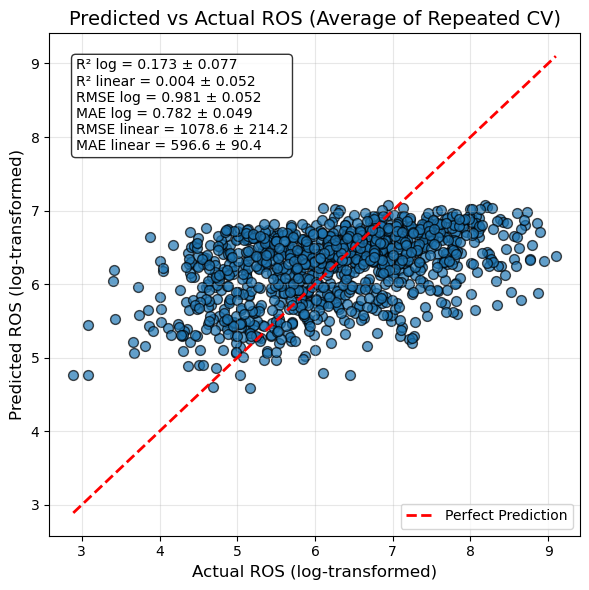

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RepeatedKFold

# ============================================================
# 1. Configurações de CV
# ============================================================
n_splits = 10
n_repeats = 5
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# ============================================================
# 2. Acumular somas e contagens para médias (Repeated CV)
# ============================================================
n_samples = len(X_model)
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred = pipeline_model.fit(X_train, y_train).predict(X_test)

    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ============================================================
# 3. Médias por observação
# ============================================================
y_pred_log_avg = y_pred_sum / y_pred_count
y_actual_log_avg = y_test_sum / y_test_count

# Função para reverter log
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

y_pred_linear_avg = inverse_safe_log(y_pred_log_avg)
y_actual_linear_avg = inverse_safe_log(y_actual_log_avg)

# ============================================================
# 4. Métricas médias por fold com std
# ============================================================
r2_folds_log = []
rmse_folds_log = []
mae_folds_log = []
r2_folds_linear = []
rmse_folds_linear = []
mae_folds_linear = []

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred_fold = pipeline_model.fit(X_train, y_train).predict(X_test)
    y_test_linear_fold = inverse_safe_log(y_test)
    y_pred_linear_fold = inverse_safe_log(y_pred_fold)

    # Log metrics
    r2_folds_log.append(r2_score(y_test, y_pred_fold))
    mae_folds_log.append(mean_absolute_error(y_test, y_pred_fold))
    rmse_folds_log.append(np.sqrt(mean_squared_error(y_test, y_pred_fold)))

    # Linear metrics
    r2_folds_linear.append(r2_score(y_test_linear_fold, y_pred_linear_fold))
    mae_folds_linear.append(mean_absolute_error(y_test_linear_fold, y_pred_linear_fold))
    rmse_folds_linear.append(np.sqrt(mean_squared_error(y_test_linear_fold, y_pred_linear_fold)))

# Média ± std
r2_log_mean, r2_log_std = np.mean(r2_folds_log), np.std(r2_folds_log)
r2_linear_mean, r2_linear_std = np.mean(r2_folds_linear), np.std(r2_folds_linear)
mae_log_mean, mae_log_std = np.mean(mae_folds_log), np.std(mae_folds_log)
rmse_log_mean, rmse_log_std = np.mean(rmse_folds_log), np.std(rmse_folds_log)
mae_linear_mean, mae_linear_std = np.mean(mae_folds_linear), np.std(mae_folds_linear)
rmse_linear_mean, rmse_linear_std = np.mean(rmse_folds_linear), np.std(rmse_folds_linear)

print(f"R² log = {r2_log_mean:.3f} ± {r2_log_std:.3f}, MAE log = {mae_log_mean:.3f} ± {mae_log_std:.3f}, RMSE log = {rmse_log_mean:.3f} ± {rmse_log_std:.3f}")
print(f"R² linear = {r2_linear_mean:.3f} ± {r2_linear_std:.3f}, MAE linear = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}, RMSE linear = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f}")

# ============================================================
# 5. Scatter plot Predicted vs Actual com ± std
# ============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_actual_log_avg, y_pred_log_avg, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_log_avg.min(), y_pred_log_avg.min())
max_val = max(y_actual_log_avg.max(), y_pred_log_avg.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Average of Repeated CV)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² log = {r2_log_mean:.3f} ± {r2_log_std:.3f}\n'
    f'R² linear = {r2_linear_mean:.3f} ± {r2_linear_std:.3f}\n'
    f'RMSE log = {rmse_log_mean:.3f} ± {rmse_log_std:.3f}\n'
    f'MAE log = {mae_log_mean:.3f} ± {mae_log_std:.3f}\n'
    f'RMSE linear = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f}\n'
    f'MAE linear = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


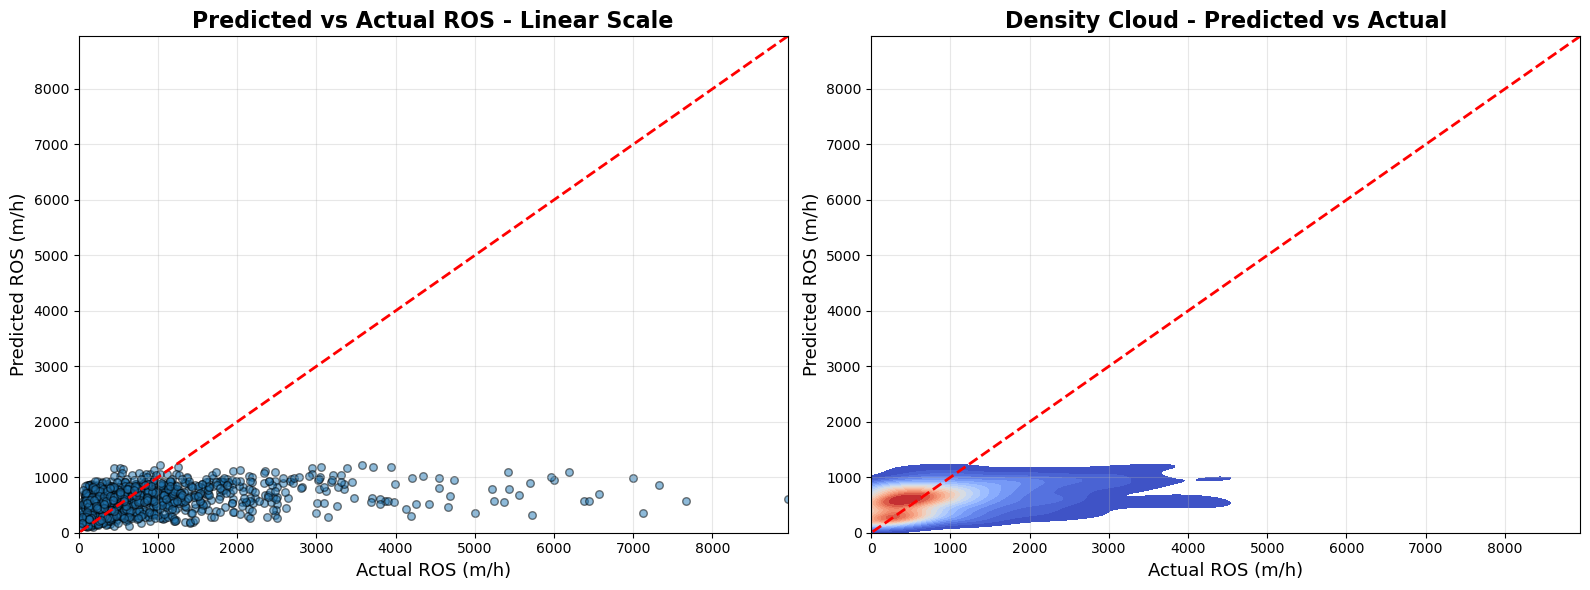

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# 1. Converter de log → linear
# ============================================================
y_actual_linear = inverse_safe_log(y_model.values)
y_pred_linear = inverse_safe_log(pipeline_model.predict(X_model))

# ============================================================
# 2. Métricas lineares
# ============================================================
r2_linear = r2_score(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)

# ============================================================
# 3. Scatter + 2D KDE plot
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# -------------------------
# Left panel: Scatter plot
# -------------------------
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# -------------------------
# Right panel: 2D KDE density plot
# -------------------------
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


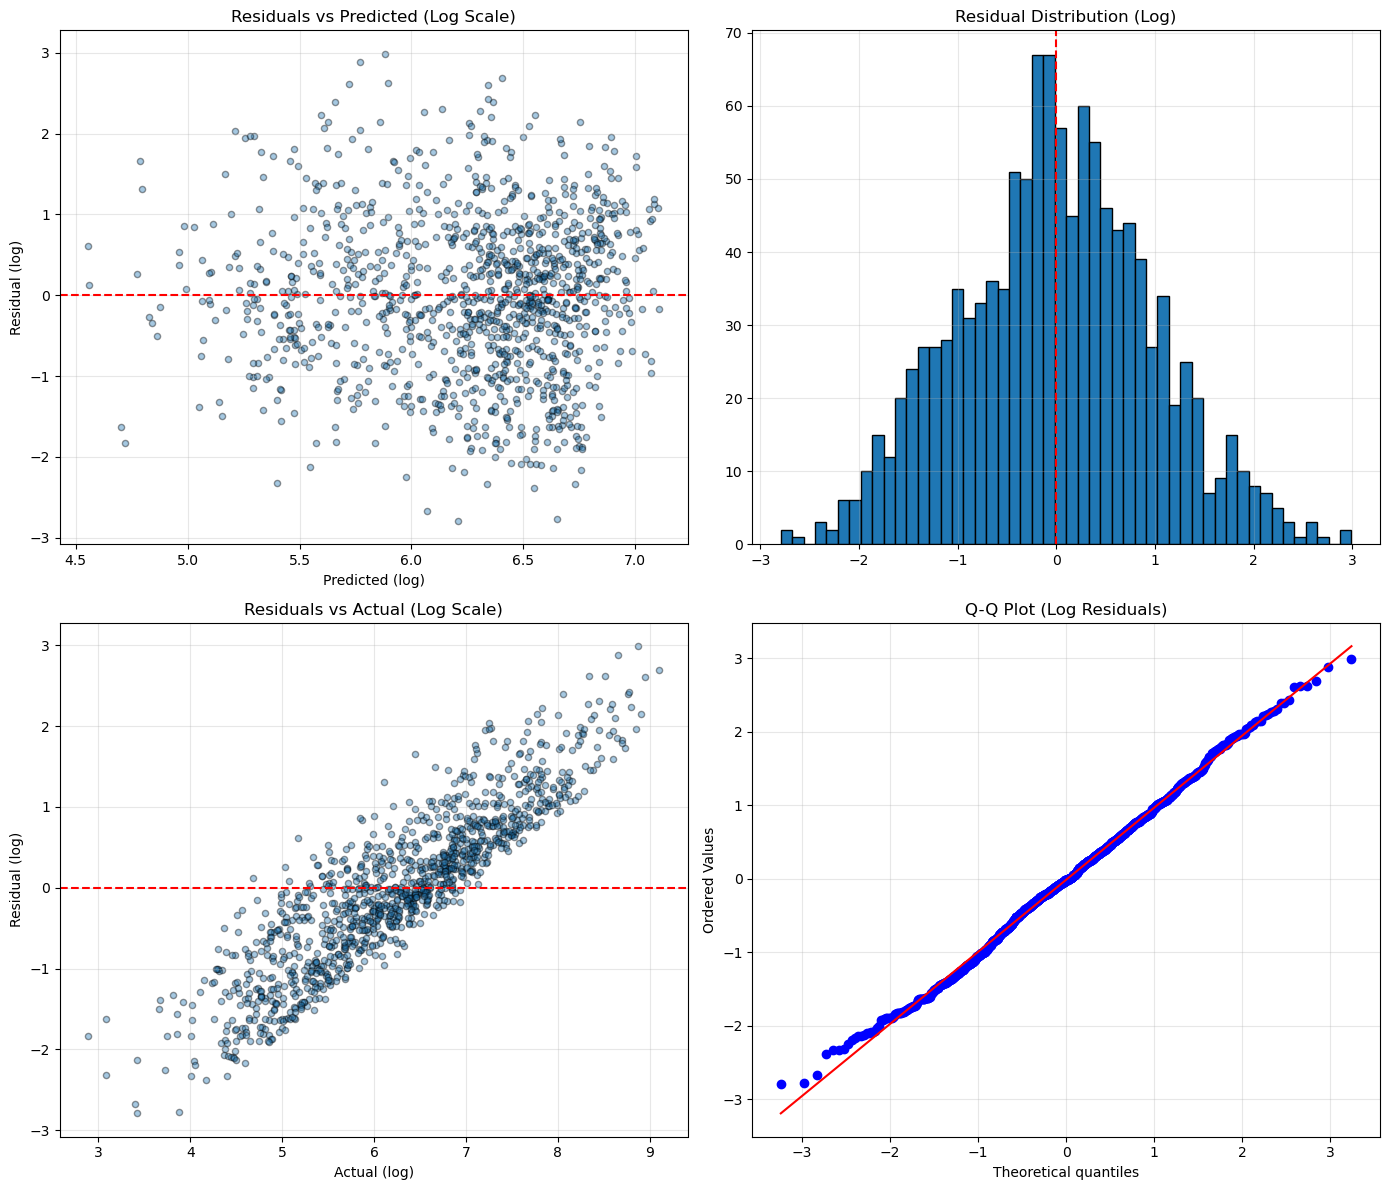

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# ============================================================
# 1. Usar médias do Repeated K-Fold
# ============================================================
avg_actual = y_model.values
avg_pred   = pipeline_model.predict(X_model)

# Conversão para escala linear, se quiser usar depois
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos na escala log
residuals_log = avg_actual - avg_pred

# ============================================================
# 2. Plots de diagnóstico dos resíduos
# ============================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# Residuals vs Predicted
# -------------------------
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# -------------------------
# Histogram of residuals
# -------------------------
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# -------------------------
# Residuals vs Actual
# -------------------------
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# -------------------------
# Q-Q Plot
# -------------------------
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


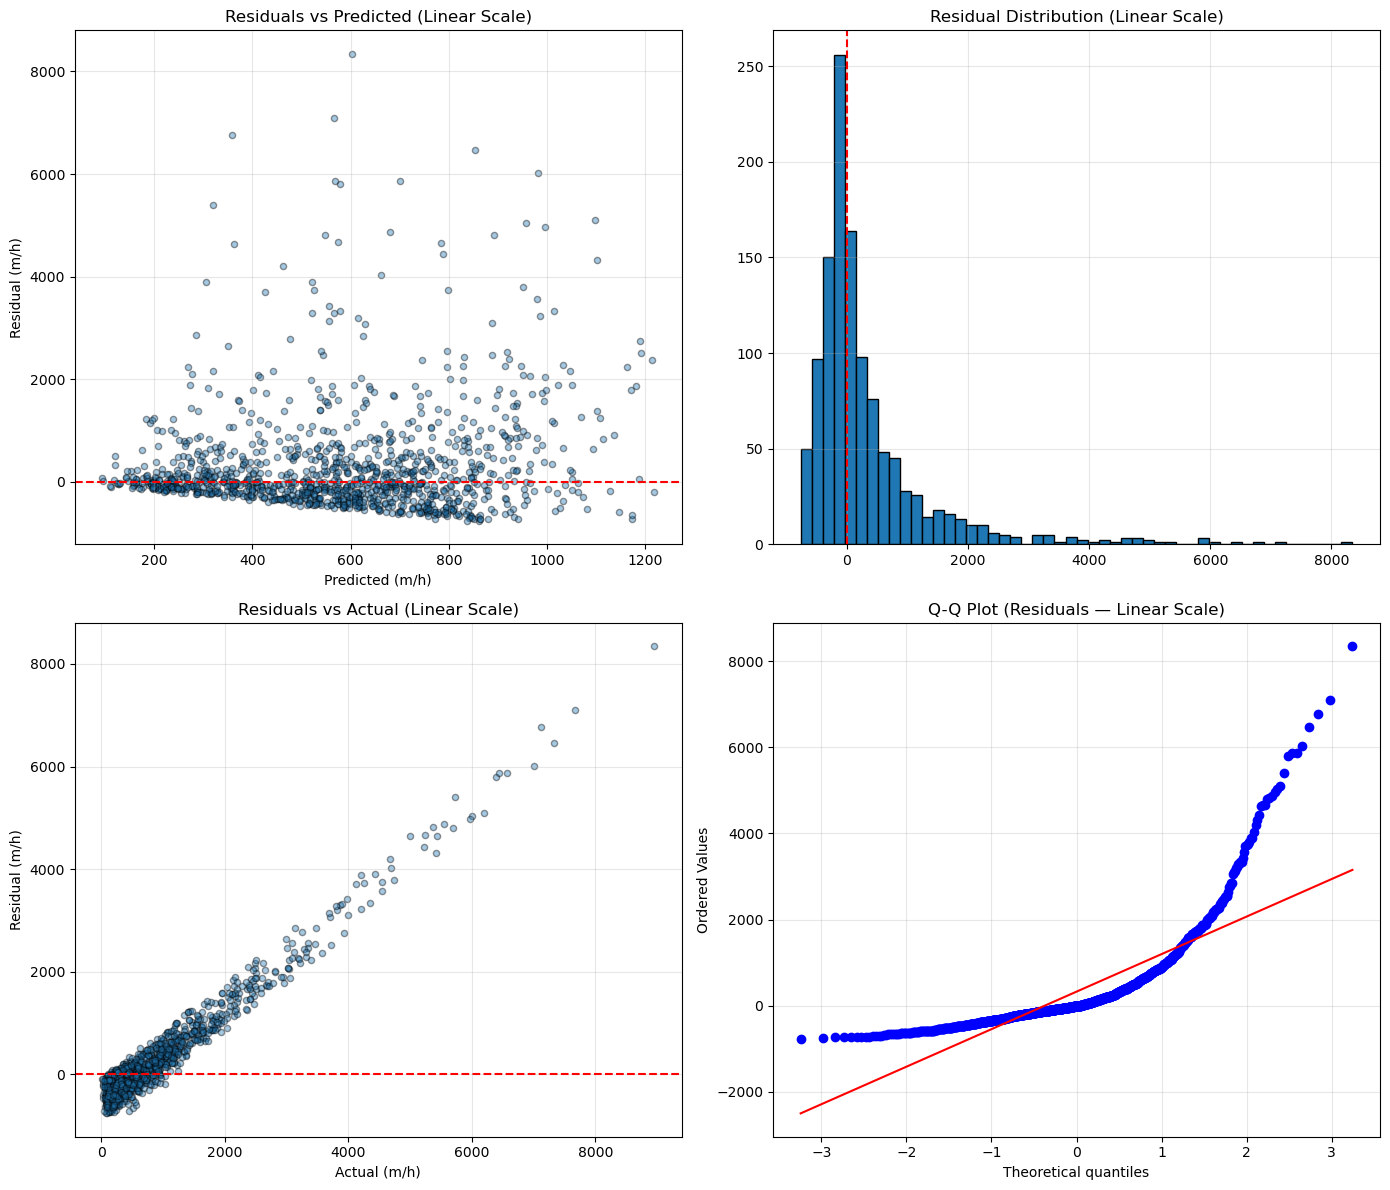

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = y_model.values
avg_pred_log   = pipeline_model.predict(X_model)

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 364  (31.0%)
Bad Predictions  : 809  (69.0%)


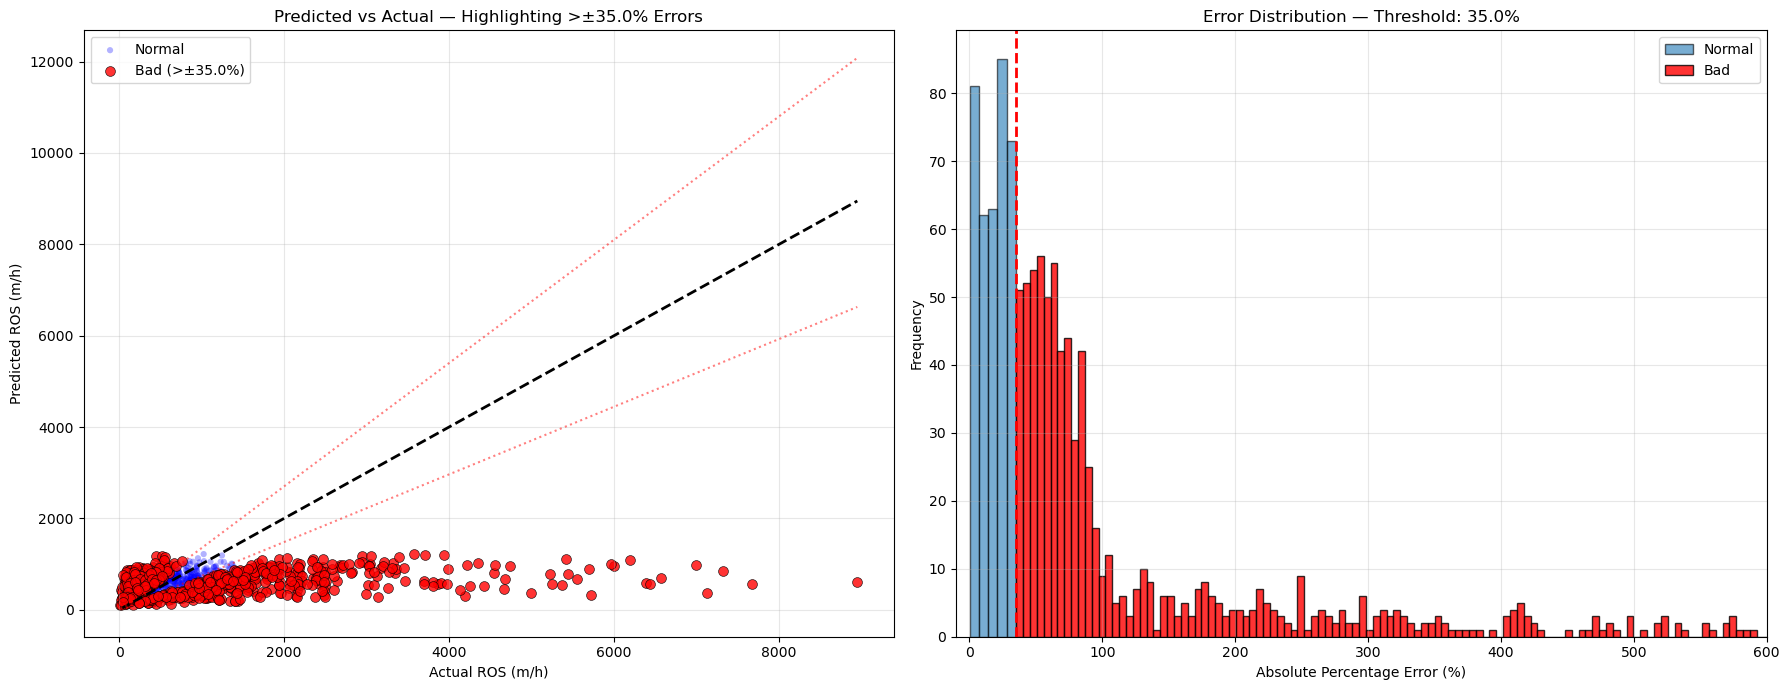

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Usar previsões do modelo final
# =============================
avg_actual_log = y_model.values
avg_pred_log   = pipeline_model.predict(X_model)

# Converter para escala linear
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()
